**This notebook loads segmentation images that contains C1 - C7 vertebae labels to combine with the CT scan train images and predicts the vertebae labels from each CT scan images with EffinientNet model.**

## Load Package

In [1]:
#! pip install pylibjpeg pylibjpeg-libjpeg pydicom
#! pip install -U python-gdcm
#! pip install opencv-python-headless
#! pip install nibabel
#! pip install tensorflow
#! pip install --upgrade tensorflow_hub
#! pip install --upgrade tensorflow-gpu
#! pip install pydicom
#! pip install path.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc

import gdcm
import pydicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom.data import get_testdata_files

from path import Path
import scipy.ndimage
from tqdm import tqdm
import nibabel as nib
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from glob import glob
import warnings
import dask.array as da

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
from keras import layers

from path import Path
from PIL import Image as im

import imageio


#from efficientnet_v2 import EfficientNetV2S
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

In [ ]:
import os
os.sys.path

In [ ]:
import sys
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\kerasapplications')
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\efficientnet-keras-source-code\\')
import keras_applications
import efficientnet.tfkeras as efficientnet

In [6]:
DEVICE = "GPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


## Helper Function

### Load Segmentation .nii file

In [ ]:
#For Segmentation data
def load_NIfTI(path):
    mask = nib.load(path)
    
    # Convert to numpy array
    seg = mask.get_fdata()
    
    # Align orientation with images
    seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
    
    return seg

In [8]:
#Getting patient with mask
seg_paths = glob(f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\segmentations\\*")
training_patient=[]
for path in seg_paths:
    training_patient.append((path.rsplit("\\",1)[-1][:-4]))#Patient with mask present training_patient.append((path.rsplit("/",1)[-1])[:-4])

#### Check with 1 patient example

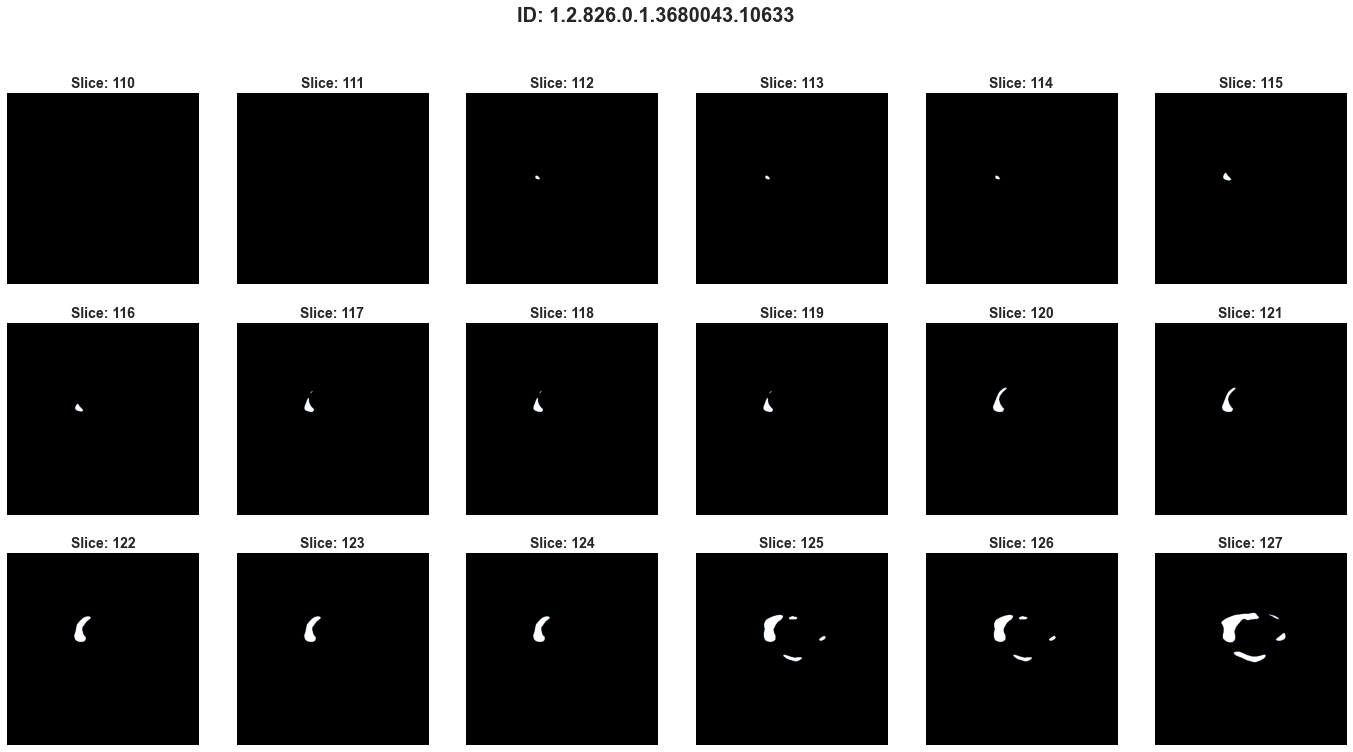

In [12]:
#Example segment image
path_mask=f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\segmentations\\{training_patient[0]}.nii"
patient_mask=load_NIfTI(path_mask)

patient_mask.shape

# Plot segment images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {training_patient[0]}', weight="bold", size=20)

start=110
for i in range(start,start+18):
    mask = patient_mask[i]
    slice_no = i

    # Plot the image
    x = (i-110) // 6
    y = (i-110) % 6

    axes[x, y].imshow(mask, cmap='bone')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

### Load Scan .dicom file

In [9]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Load the scans in given folder path
def load_scan(path):
    
    dcm_paths = glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    
    patient_scan = [pydicom.dcmread(paths) for paths in dcm_paths]
    
    return patient_scan

#### Check with 1 patient example

In [46]:
#Example Scan
path_scan=f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images\\1.2.826.0.1.3680043.581"
image=load_scan(path_scan)

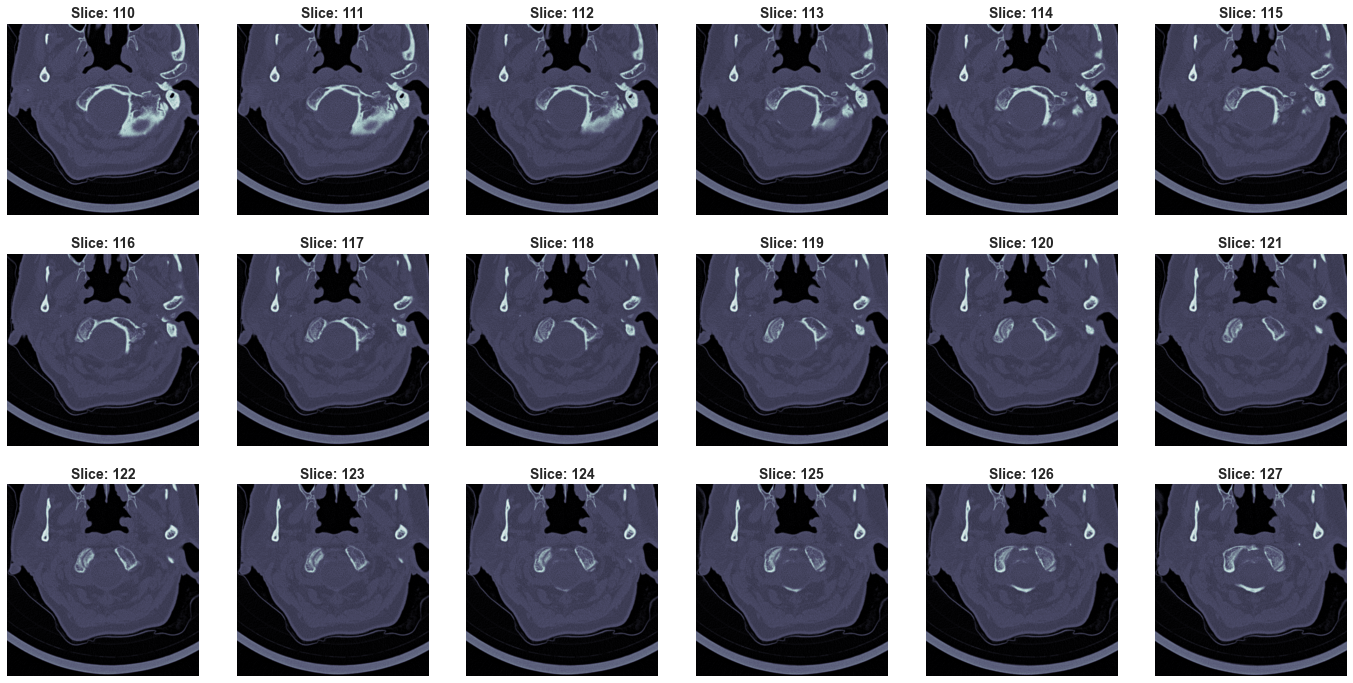

In [43]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
#fig.suptitle(f'ID: {training_patient[0]}', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = image[i].pixel_array
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

### HU Rescale

In [47]:
def get_pixels_hu(slices):
   
    image = np.stack([cv2.resize(s.pixel_array,(256,256),interpolation = cv2.INTER_NEAREST) for s in slices])
    #image = np.stack([cv2.cvtColor(s.pixel_array.reshape(512,512),cv2.COLOR_GRAY2RGB) for s in slices])

    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16) #int16
    image = da.from_array(image) #Using Dask to speed up processing
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    #print(slope.shape)
    #print(image.shape)
    image= slope * image.astype("float64")
    #print(image.shape)   
    image+= intercept
    #print(image.shape)      
    return image.astype("int16")

(-0.5, 511.5, 511.5, -0.5)

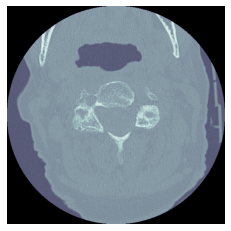

In [48]:
#Ploting pixel array
plt.imshow(image[110].pixel_array,cmap='bone')
plt.axis("off")

In [61]:
cv2.resize(image[110].pixel_array, (256 , 256),interpolation = cv2.INTER_NEAREST)

array([[331,  45,   0, ...,   0,   0,   0],
       [562, 270,   0, ...,   0,   0,   0],
       [410, 698, 215, ..., 190,   0,   0],
       ...,
       [ 30,   0,  54, ...,   0,  50,  63],
       [ 27,  30,   0, ...,  40,  26,  53],
       [  0,   0,  25, ...,  29,  36,   0]], dtype=uint16)

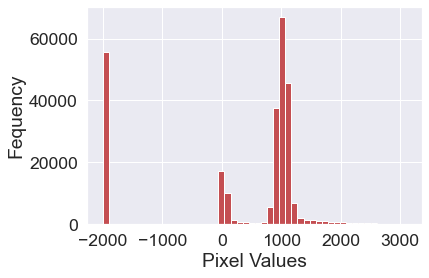

In [49]:
#Ploting pixel array distribution
plt.hist(image[110].pixel_array.flatten(),color="r",bins=50)
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")
plt.show()

(-0.5, 255.5, 255.5, -0.5)

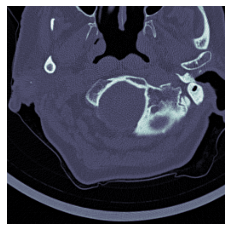

In [63]:
patient_slice=get_pixels_hu(image)

#Ploting HU array
plt.imshow(patient_slice[110],cmap='bone')
plt.axis("off")

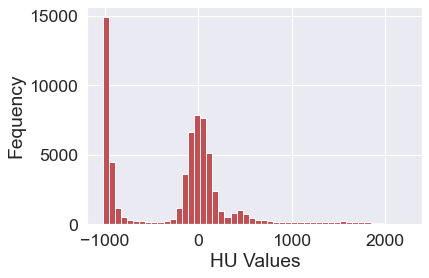

In [64]:
#Ploting HU distribution
plt.hist(patient_slice[110].flatten().compute(),color="r",bins=50)
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.show()

### Normalization

In [ ]:
MIN_BOUND = 150.0
MAX_BOUND = 2050.0
    
def normalize(image):
    image = (image - MIN_BOUND)*255.0 / (MAX_BOUND - MIN_BOUND)
    image[image>255] = 255.
    image[image<0] = 255.
    
    image = image.astype(np.int16)
    return image

(-0.5, 255.5, 255.5, -0.5)

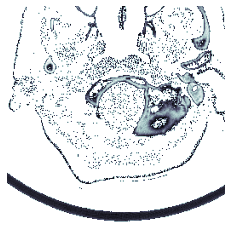

In [66]:
image=normalize(patient_slice)

plt.imshow(image[110],cmap="bone")
plt.axis("off")

In [68]:
#Delete all unused objects to free up memory
del patient_slice
del image

gc.collect()

67342

## Model

### Train Test Split

In [67]:
X_train_patient, X_Val_patient = train_test_split(training_patient,train_size=70,test_size=17,shuffle=True)

In [13]:
len(X_train_patient)

70

In [23]:
#X_train_patient = ['1.2.826.0.1.3680043.10633','1.2.826.0.1.3680043.10921']
#X_Val_patient = ['1.2.826.0.1.3680043.11827','1.2.826.0.1.3680043.11988','1.2.826.0.1.3680043.12281']

### Training Cell based on segmentation data

In [69]:
#Segreggate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_Train():
    
    train_ds_x=[]
    train_ds_y=[]
    #for i in range(start,start+10):
    #for i in range(len(X_train_patient)):
    for i in range(15):
        patient_ID=X_train_patient[i]
        
        patient_seg=load_NIfTI(f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\segmentations\\{patient_ID}.nii")
        
        patient_scan=load_scan(f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images\\{patient_ID}") #need to change back
        patient_hu=get_pixels_hu(patient_scan)
        patient_hu_normalised=normalize(patient_hu)
        
        for j in tqdm(range(0,len(patient_seg))):
            classes=np.unique(patient_seg[j])
        
            temp_lables=np.zeros(9)
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)]=1
                    else:
                        temp_lables[8]=1
                else:
                    temp_lables[0]=1
            
            train_ds_x.append(patient_hu_normalised[j].astype(np.uint8))
            train_ds_y.append(temp_lables.astype(np.uint8))
        
    return train_ds_x,train_ds_y

### Validation Cell based on segmentation data

In [70]:
#Segreggate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_Val():
    
    val_ds_x=[]
    val_ds_y=[]
    #for i in range(len(X_Val_patient)):
    for i in range(5):
        patient_ID=X_Val_patient[i]
        
        patient_seg=load_NIfTI(f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\segmentations\\{patient_ID}.nii")
        
        patient_scan=load_scan(f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images\\{patient_ID}") #need to change back
        patient_hu=get_pixels_hu(patient_scan)
        patient_hu_normalised=normalize(patient_hu)
        
        for j in tqdm(range(0,len(patient_seg))):
            classes=np.unique(patient_seg[j])
        
            temp_lables=np.zeros(9)
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)]=1
                    else:
                        temp_lables[8]=1
                else:
                    temp_lables[0]=1
            
            val_ds_x.append(patient_hu_normalised[j].astype(np.uint8))
            val_ds_y.append(temp_lables.astype(np.uint8))
        
    return val_ds_x,val_ds_y

#### Call this in a loop to train the model in folds

In [19]:
train_ds_x,train_ds_y=segregate_Train()
val_ds_x,val_ds_y=segregate_Val()

100%|██████████| 348/348 [00:01<00:00, 215.24it/s]


#### Convert into specific format from tensorflow model

In [20]:
train_ds_x_updated=np.array(train_ds_x)
train_ds_y_updated=np.array(train_ds_y)
val_ds_x_updated=np.array(val_ds_x)
val_ds_y_updated=np.array(val_ds_y)

In [21]:
print(train_ds_x_updated.shape)
print(train_ds_y_updated.shape)
print(val_ds_x_updated.shape)
print(val_ds_y_updated.shape)

(4596, 512, 512)
(4596, 9)
(1373, 512, 512)
(1373, 9)


#### Save data as backup

In [32]:
train_ds_x_updated_reshaped = train_ds_x_updated.reshape(train_ds_x_updated.shape[0], -1)
val_ds_x_updated_reshaped = val_ds_x_updated.reshape(val_ds_x_updated.shape[0], -1)

# saving reshaped array to file.
np.savetxt("train_ds_x_updated_reshaped.txt", train_ds_x_updated_reshaped)
np.savetxt("train_ds_y_updated.txt", train_ds_y_updated)
np.savetxt("val_ds_x_updated_reshaped.txt", val_ds_x_updated_reshaped)
np.savetxt("val_ds_y_updated.txt", val_ds_y_updated)

In [ ]:
train_ds_x_updated_reshaped = np.loadtxt('train_ds_x_updated_reshaped.txt')
train_ds_y_updated = np.loadtxt('train_ds_y_updated.txt')
val_ds_x_updated_reshaped = np.loadtxt('val_ds_x_updated_reshaped.txt')
val_ds_y_updated = np.loadtxt('val_ds_y_updated.txt')

train_ds_x_updated = train_ds_x_updated_reshaped.reshape(train_ds_x_updated_reshaped.shape[0], train_ds_x_updated_reshaped.shape[1] // 512, 512)
val_ds_x_updated = val_ds_x_updated_reshaped.reshape(val_ds_x_updated_reshaped.shape[0], val_ds_x_updated_reshaped.shape[1] // 512, 512)

In [22]:
print(val_ds_y_updated[170])

[1 0 0 0 1 1 0 0 0]


#### Reshape data to file into EfficientNet

In [23]:
train_ds_x_updated=np.reshape(train_ds_x_updated,(-1,512,512,1)) #(-1,512,512,1)
val_ds_x_updated=np.reshape(val_ds_x_updated,(-1,512,512,1)) #(-1,512,512,1)

In [24]:
print(train_ds_x_updated.shape)
print(train_ds_y_updated.shape)
print(val_ds_x_updated.shape)
print(val_ds_y_updated.shape)

(4596, 512, 512, 1)
(4596, 9)
(1373, 512, 512, 1)
(1373, 9)


In [23]:
del model
gc.collect()

58748

### Build Model

In [25]:
def get_model():
    inp = keras.layers.Input((None, None ,1))
    x = Conv2D(3, 3, padding = 'SAME')(inp)
    x = efficientnet.EfficientNetB5(include_top=False, weights='imagenet')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(9, 'sigmoid')(x) #7
    model = keras.models.Model(inp, out)
    model.summary()
    #model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)) #0.0005
    
    return model

In [28]:
model = get_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 efficientnet-b5 (Functional  (None, None, None, 2048)  28513520 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 28,531,991
Trainable params: 28,359,255
Non-tra

In [29]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium   amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), #0.0005,0.0001, 0.00005
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Train Model

In [ ]:
history=model.fit(train_ds_x_updated,train_ds_y_updated,
                  epochs=20, #50
                  use_multiprocessing=True,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_data=(val_ds_x_updated,val_ds_y_updated))

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Max validation accuracy: {}".format(history_df['val_accuracy'].max()))

In [ ]:
model.save("Classifier_v3.h5")

In [ ]:
val_pred = model.predict(val_ds_x_updated,
                         use_multiprocessing=True)    

#### Save model

In [ ]:
np.savetxt("val_pred.txt", val_pred)

## Error Analysis

In [45]:
model = keras.models.load_model('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\Classifier_v3.h5')

In [11]:
val_pred = np.loadtxt('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\val_pred.txt')


In [12]:
val_ds_y_updated = np.loadtxt('val_ds_y_updated.txt')

In [13]:
val_pred[350]

array([0.96589148, 0.85425651, 0.95853335, 0.12818202, 0.03242435,
       0.02598392, 0.02196274, 0.01488489, 0.01484317])

### Find Classification Threshold

In [14]:
threshold=0.5
def pred_label(threshold=0.5):
    val_pred_cleaned = []
    for i in val_pred:
        image_clean = []
        for j in i:
            if j >threshold:
                image_clean.append(1.0)
            else:
                image_clean.append(0.0)
        image_clean = np.array(image_clean)

        val_pred_cleaned.append(image_clean)
        
    return val_pred_cleaned

In [17]:
val_pred_cleaned = pred_label(0.60)

In [82]:
val_pred_cleaned[350]

array([1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [27]:
val_ds_y_updated[350]


array([1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [28]:
val_pred_cleaned[950]

array([1., 0., 0., 0., 0., 0., 0., 0., 1.])

In [30]:
val_ds_y_updated[950]


array([1., 0., 0., 0., 0., 0., 0., 0., 1.])

In [31]:
val_pred_cleaned[150]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
val_ds_y_updated[150]

array([1., 0., 0., 1., 1., 0., 0., 0., 0.])

### Check Accuracy of Model

In [15]:
def acc_calc(val, pred):
    accuracy = []
    for i in range(len(val)):
        acc_count = 0
        for j in range(len(val[i])):
            if val[i][j] == pred[i][j]:
                acc_count +=1

        accuracy.append(acc_count/9)
    return accuracy


In [18]:
np.mean(acc_calc(val_ds_y_updated,val_pred_cleaned))

0.9012705349194787

In [23]:
incr = list(range(30,70,2))
acc_list = []
for i in incr:
    val_ds_y_list = pred_label(i/100)
    acc_list.append(np.mean(acc_calc(val_ds_y_updated,val_ds_y_list)))

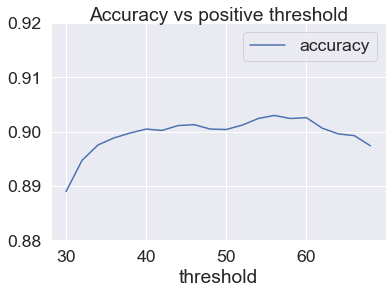

In [39]:
acc_threshold = pd.DataFrame()
acc_threshold['threshold'] = incr
acc_threshold['accuracy'] = acc_list
acc_threshold.plot(x ='threshold', y='accuracy', kind = 'line')
plt.title(label='Accuracy vs positive threshold', 
          fontweight=10, 
          pad='2.0')
plt.ylim([0.88, 0.92])
plt.show()


In [26]:
acc_threshold

,threshold,accuracy
0,30,0.888970
1,32,0.894716
2,34,0.897548
3,36,0.898843
4,38,0.899733
5,40,0.900461
6,42,0.900218
7,44,0.901109
8,46,0.901271
9,48,0.900461


### Sample output

In [35]:
print('actual label: ')
print(val_ds_y_updated[800])
print('\npredicted output: ')
print(val_pred[800])
print('\npredicted label: ')
print(val_pred_cleaned[800])

actual label: 
[1. 1. 1. 0. 0. 0. 0. 0. 0.]

predicted output: 
[0.92639005 0.88605517 0.84040582 0.05682087 0.03717361 0.0239842
 0.0283552  0.03207355 0.04325184]

predicted label: 
[1. 1. 1. 0. 0. 0. 0. 0. 0.]
